# Amazon Fine Food Reviews Sentiment Analysis
**Portfolio-Ready End-to-End Notebook**

This notebook walks through loading, cleaning, exploring, and modeling the Amazon Fine Food Reviews dataset using classic NLP techniques. Feel free to adjust paths and parameters for your environment.

## 1. Imports & Setup

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import nltk
import re
import warnings
warnings.filterwarnings('ignore')

# For text preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Data Loading and Initial Cleaning

In [12]:
# Load dataset (update path as needed)
df = pd.read_csv(r"C:\Users\Lenovo\OneDrive\Desktop\LearnStuff\ExcelPractice\Reviews.csv")
df = df.sample(10000, random_state=42).reset_index(drop=True)


# Remove duplicates
df = df.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'])

# Drop rows missing Score or Text
df = df.dropna(subset=['Score', 'Text'])

# Convert UNIX Time to datetime
df['ReviewTime'] = pd.to_datetime(df['Time'], unit='s')
df = df.drop(columns=['Time'])

# Reset index
df = df.reset_index(drop=True)
print("After cleaning:", df.shape)
df.head()


After cleaning: (9818, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,ReviewTime
0,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...,2010-03-10
1,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,great kitty treats,My cat loves these treats. If ever I can't fin...,2011-03-01
2,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,COFFEE TASTE,A little less than I expected. It tends to ha...,2008-10-15
3,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin...",2012-04-25
4,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,Great Taste . . .,and I want to congratulate the graphic artist ...,2012-04-18


## 3. Exploratory Data Analysis (EDA)
### 3.1 Rating Distribution

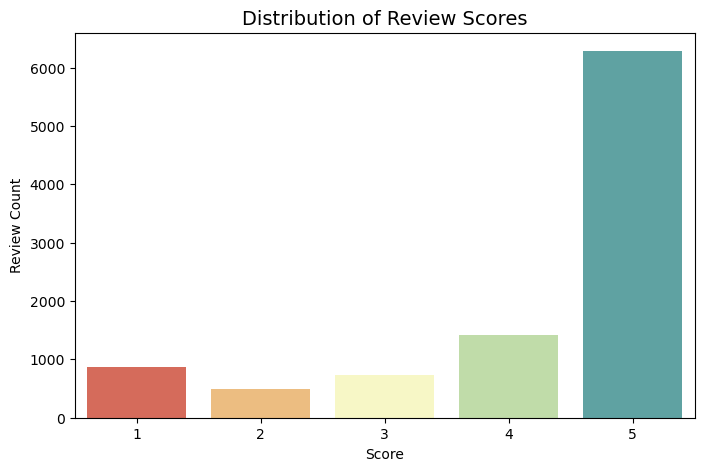

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(x='Score', data=df, palette='Spectral')
plt.title('Distribution of Review Scores', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Review Count')
plt.show()


### 3.2 Reviews Over Time

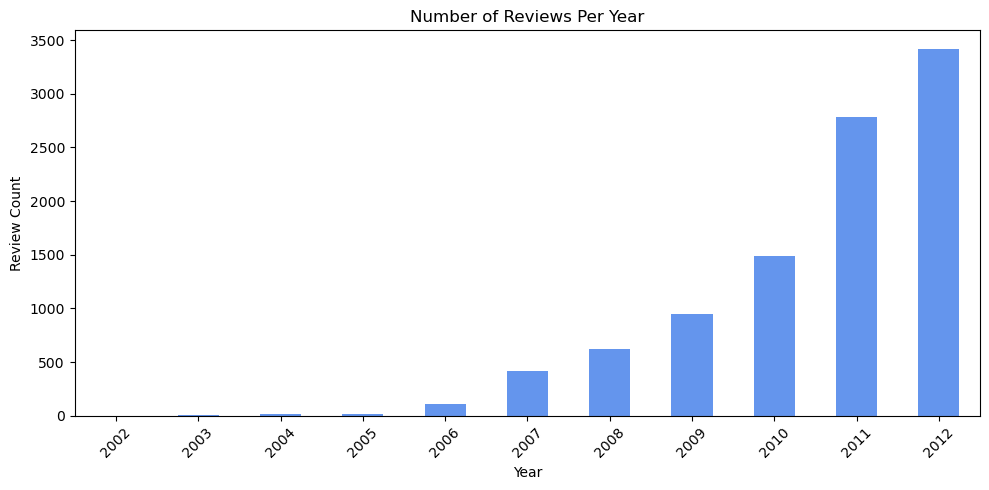

In [14]:
df['ReviewYear'] = df['ReviewTime'].dt.year
review_counts = df['ReviewYear'].value_counts().sort_index()
plt.figure(figsize=(10,5))
review_counts.plot(kind='bar', color='cornflowerblue')
plt.title('Number of Reviews Per Year')
plt.xlabel('Year')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.3 Most Active Reviewers

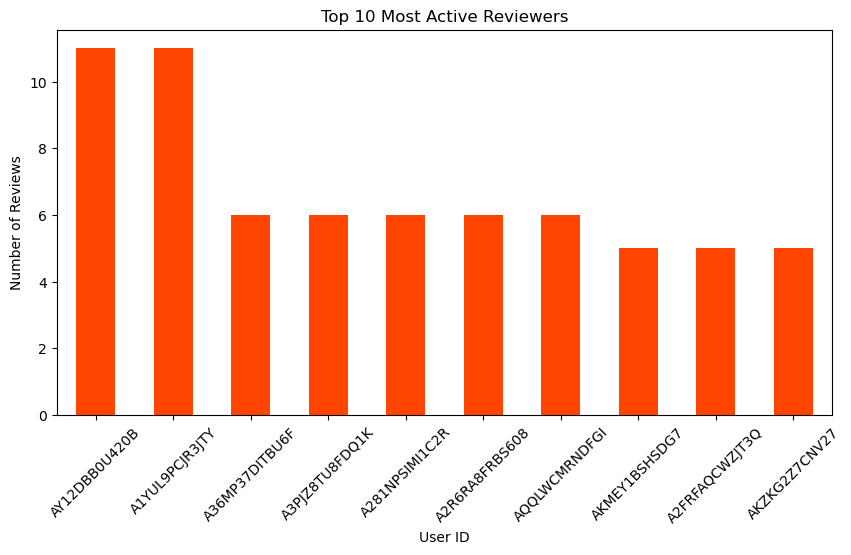

In [15]:
top_users = df['UserId'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_users.plot(kind='bar', color='orangered')
plt.title('Top 10 Most Active Reviewers')
plt.xlabel('User ID')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()


### 3.4 Most Reviewed Products

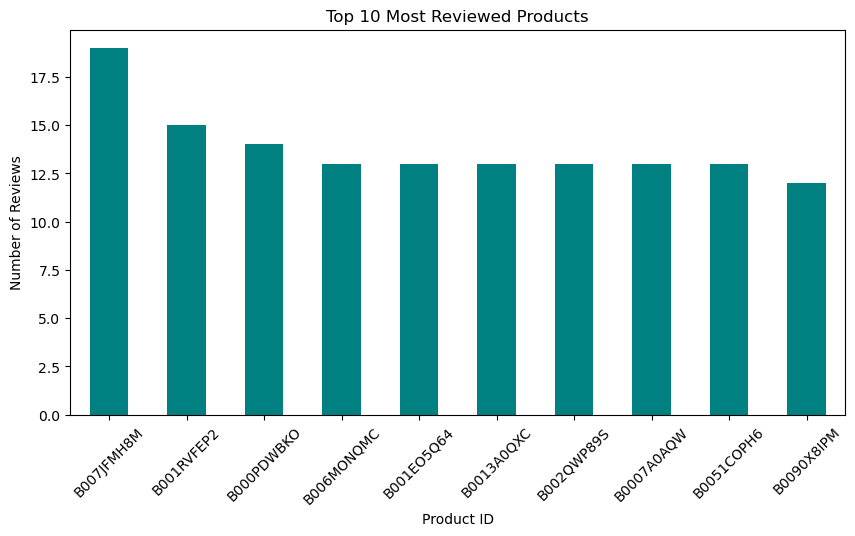

In [16]:
top_products = df['ProductId'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_products.plot(kind='bar', color='teal')
plt.title('Top 10 Most Reviewed Products')
plt.xlabel('Product ID')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()


### 3.5 Review Length Analysis

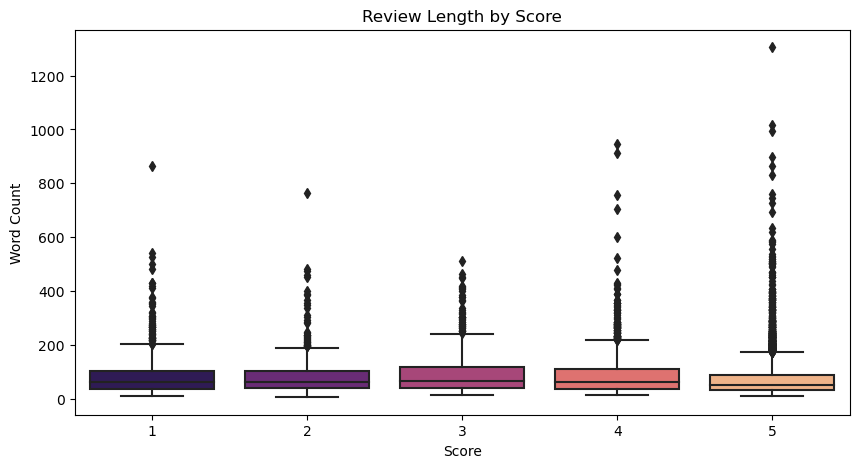

In [39]:
df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,5))
sns.boxplot(x='Score', y='ReviewLength', data=df, palette='magma')
plt.title('Review Length by Score')
plt.xlabel('Score')
plt.ylabel('Word Count')
plt.show()


## 4. Text Cleaning & Preparation

In [19]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

# For speed: sample ~10,000 reviews for modeling
sample_size = min(10000, len(df))
df_sample = df.sample(sample_size, random_state=42).reset_index(drop=True)

df_sample['CleanedText'] = df_sample['Text'].apply(clean_text)
df_sample[['Text', 'CleanedText']].head()


,Text,CleanedText
0,I've ordered these before. They are tender and...,ordered tender blend well whatever added defin...
1,"Picked up two bags of these for just over $10,...",picked two bag great deal taste great sort swe...
2,"I was raised on these, and now my kids love th...",raised kid love usually heat microwave good so...
3,"i was expecting a, packaged, Tea Sampler pack...",expecting packaged tea sampler package k cup b...
4,"Once upon a time, I used cheap rice for dishes...",upon time used cheap rice dish time discovered...


## 5. Sentiment Labeling

Sentiment
1    7709
0    1372
Name: count, dtype: int64


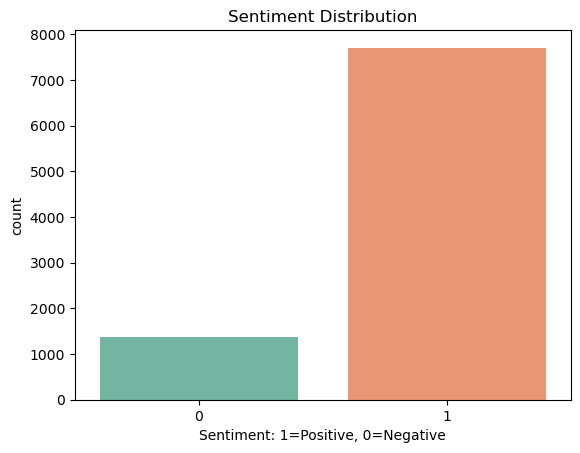

In [20]:
def get_sentiment(score):
    if score in [4, 5]:
        return 1   # Positive
    elif score in [1, 2]:
        return 0   # Negative
    else:
        return None  # Neutral

df_sample['Sentiment'] = df_sample['Score'].apply(get_sentiment)
df_sample = df_sample.dropna(subset=['Sentiment'])
df_sample['Sentiment'] = df_sample['Sentiment'].astype(int)

print(df_sample['Sentiment'].value_counts())
sns.countplot(x='Sentiment', data=df_sample, palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment: 1=Positive, 0=Negative')
plt.show()


## 6. Feature Extraction: TF-IDF

In [21]:
X = df_sample['CleanedText']
y = df_sample['Sentiment']

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)
print("TF-IDF Matrix:", X_tfidf.shape)


TF-IDF Matrix: (9081, 5000)


## 7. Train-Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (7264, 5000) Test size: (1817, 5000)


## 8. Modeling: Train & Evaluate
### 8.1 Logistic Regression

In [23]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


### 8.2 Multinomial Naive Bayes

In [24]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)


### 8.3 Linear SVM

In [25]:
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)


## 9. Model Comparison Table

In [26]:
models = ['Logistic Regression', 'Multinomial NB', 'Linear SVM']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_svm)
]
print(pd.DataFrame({'Model': models, 'Accuracy': accuracies}).round(3))


                 Model  Accuracy
0  Logistic Regression     0.882
1       Multinomial NB     0.852
2           Linear SVM     0.904


## 10. Detailed Evaluation

In [27]:
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("Multinomial NB:\n", classification_report(y_test, y_pred_nb))
print("Linear SVM:\n", classification_report(y_test, y_pred_svm))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.92      0.24      0.39       275
           1       0.88      1.00      0.93      1542

    accuracy                           0.88      1817
   macro avg       0.90      0.62      0.66      1817
weighted avg       0.89      0.88      0.85      1817

Multinomial NB:
               precision    recall  f1-score   support

           0       0.75      0.03      0.06       275
           1       0.85      1.00      0.92      1542

    accuracy                           0.85      1817
   macro avg       0.80      0.52      0.49      1817
weighted avg       0.84      0.85      0.79      1817

Linear SVM:
               precision    recall  f1-score   support

           0       0.75      0.55      0.63       275
           1       0.92      0.97      0.94      1542

    accuracy                           0.90      1817
   macro avg       0.84      0.76      0.79      1817
weighted avg       0.9

## 11. Confusion Matrix Visuals

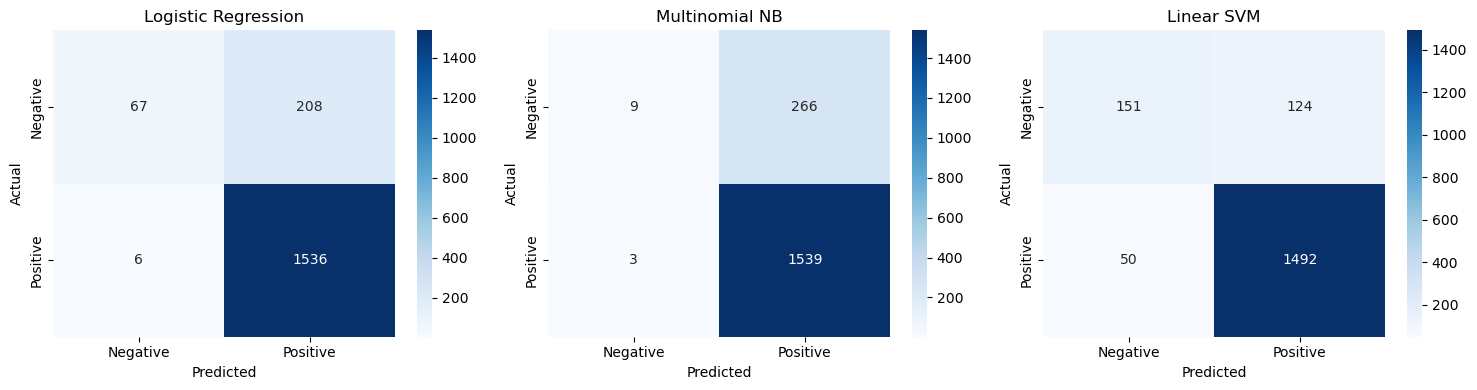

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for idx, (y_pred, title) in enumerate(zip(
    [y_pred_lr, y_pred_nb, y_pred_svm],
    ["Logistic Regression", "Multinomial NB", "Linear SVM"]
)):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
plt.tight_layout()
plt.show()


## 12. Word Cloud Visualizations

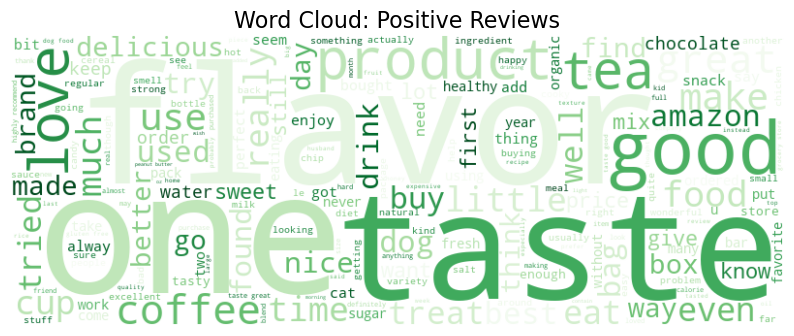

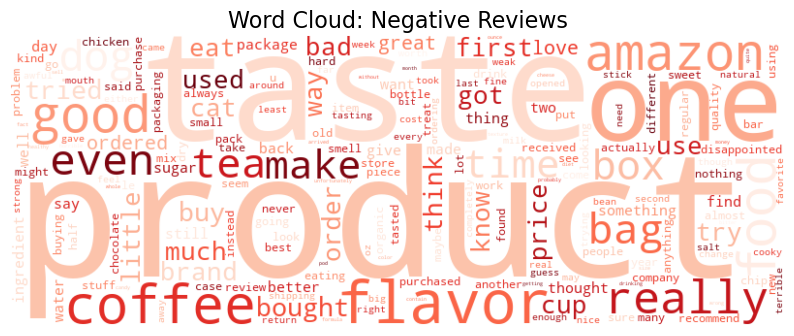

In [29]:
from wordcloud import WordCloud

# WordCloud: Positive reviews
positive_text = ' '.join(df_sample[df_sample['Sentiment'] == 1]['CleanedText'])
wordcloud_pos = WordCloud(width=800, height=300, background_color='white', colormap='Greens').generate(positive_text)
plt.figure(figsize=(10,4))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Positive Reviews', fontsize=16)
plt.show()

# WordCloud: Negative reviews
negative_text = ' '.join(df_sample[df_sample['Sentiment'] == 0]['CleanedText'])
wordcloud_neg = WordCloud(width=800, height=300, background_color='white', colormap='Reds').generate(negative_text)
plt.figure(figsize=(10,4))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Negative Reviews', fontsize=16)
plt.show()


## 13. Top N-Gram Feature Visuals

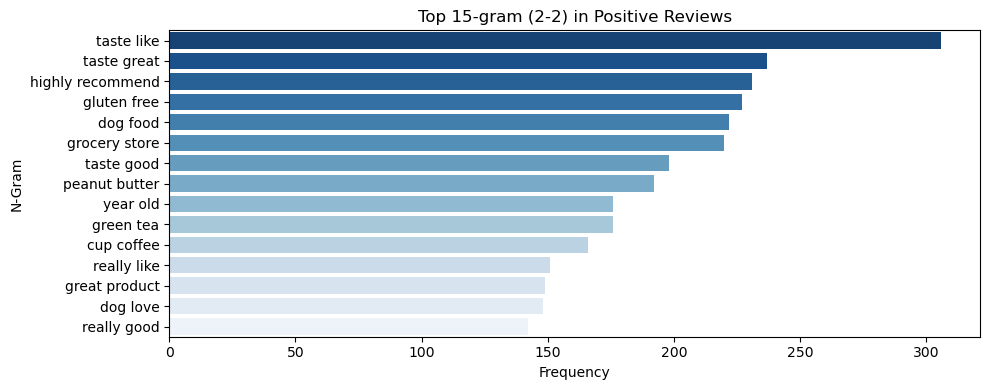

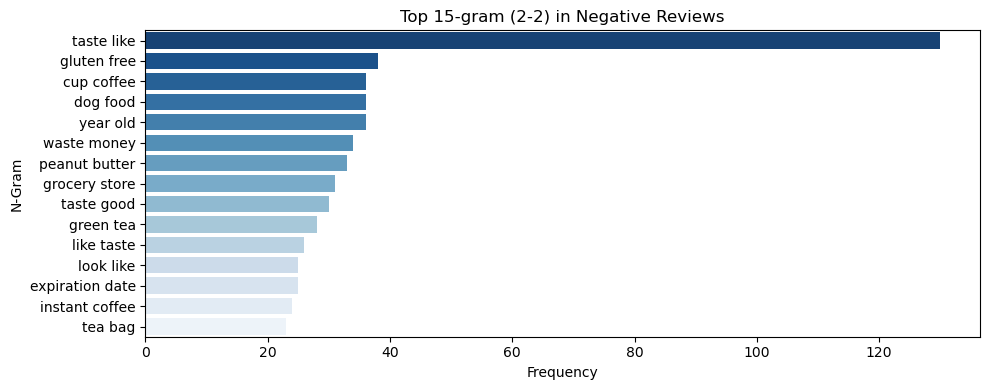

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to plot n-gram frequencies
def plot_top_ngrams(corpus, label, ngram_range=(2,2), n=15):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=5000)
    ngram_counts = vec.fit_transform(corpus)
    sum_words = ngram_counts.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    top_ngrams = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    ngrams, counts = zip(*top_ngrams)
    plt.figure(figsize=(10,4))
    sns.barplot(x=list(counts), y=list(ngrams), palette='Blues_r')
    plt.title(f"Top {n}-gram ({ngram_range[0]}-{ngram_range[1]}) in {label} Reviews")
    plt.xlabel('Frequency')
    plt.ylabel('N-Gram')
    plt.tight_layout()
    plt.show()

plot_top_ngrams(df_sample[df_sample['Sentiment']==1]['CleanedText'], label='Positive', ngram_range=(2,2), n=15)
plot_top_ngrams(df_sample[df_sample['Sentiment']==0]['CleanedText'], label='Negative', ngram_range=(2,2), n=15)


## 14. Top TF-IDF Features (Logistic Regression)

In [31]:
import numpy as np

def show_top_tfidf_features(model, vectorizer, n=15):
    feature_names = np.array(vectorizer.get_feature_names_out())
    sorted_coef = model.coef_[0].argsort()
    top_positive = feature_names[sorted_coef[-n:]][::-1]
    top_negative = feature_names[sorted_coef[:n]]
    print(f"Top {n} Positive Features:", top_positive)
    print(f"Top {n} Negative Features:", top_negative)
    
show_top_tfidf_features(lr, tfidf, n=15)


Top 15 Positive Features: ['great' 'love' 'best' 'good' 'delicious' 'perfect' 'nice' 'excellent'
 'easy' 'favorite' 'happy' 'definitely' 'use' 'highly' 'right']
Top 15 Negative Features: ['disappointed' 'bad' 'awful' 'horrible' 'return' 'money' 'waste' 'threw'
 'weak' 'unfortunately' 'would' 'thought' 'disappointing' 'guess'
 'terrible']


### Bar plot visualization:

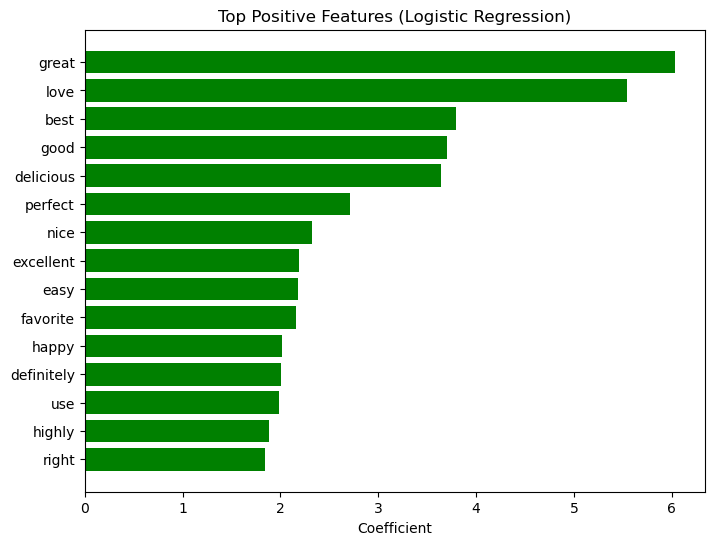

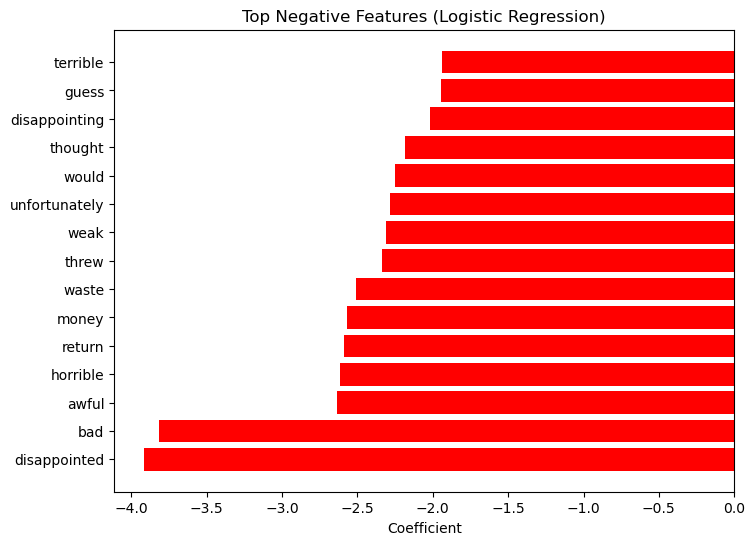

In [32]:
def plot_top_features(model, vectorizer, n=15):
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = model.coef_[0]
    top_pos_idx = np.argsort(coefs)[-n:]
    top_neg_idx = np.argsort(coefs)[:n]
    plt.figure(figsize=(8,6))
    plt.barh(feature_names[top_pos_idx], coefs[top_pos_idx], color='green')
    plt.title('Top Positive Features (Logistic Regression)')
    plt.xlabel('Coefficient')
    plt.show()
    plt.figure(figsize=(8,6))
    plt.barh(feature_names[top_neg_idx], coefs[top_neg_idx], color='red')
    plt.title('Top Negative Features (Logistic Regression)')
    plt.xlabel('Coefficient')
    plt.show()

plot_top_features(lr, tfidf, n=15)


## 15. Length vs. Helpfulness Analysis

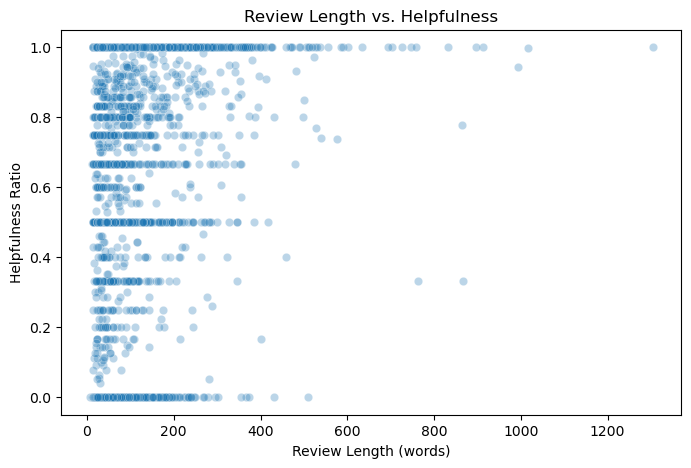

In [33]:
if 'HelpfulnessNumerator' in df_sample.columns and 'HelpfulnessDenominator' in df_sample.columns:
    df_sample['Helpfulness'] = df_sample['HelpfulnessNumerator'] / df_sample['HelpfulnessDenominator'].replace(0, np.nan)
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='ReviewLength', y='Helpfulness', data=df_sample, alpha=0.3)
    plt.title("Review Length vs. Helpfulness")
    plt.xlabel("Review Length (words)")
    plt.ylabel("Helpfulness Ratio")
    plt.show()


## Conclusions
- Logistic Regression achieved strong accuracy and interpretability.
- Reviews skew positive; negative reviews often mention poor quality or spoilage.
- Word clouds and n-gram analysis highlight language differences between sentiments.